## Importing Libraries

This project will make use of libraries like numpy, pandas, matplotlib, seaborn, scikit-learn, nltk and wordcloud.

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Loading the Dataset

chunks = []

r_dtypes = {"stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32} 

# Store the json chunks
reader = pd.read_json('yelp_academic_dataset_review.json',
                      lines=True,
                      chunksize=1000,
                      dtype=r_dtypes,
                      orient='records')

# For loop to append each chunk into the chunks list
for chunk in reader:
        reduced_chunk = chunk.drop(columns=['review_id', 'user_id'])\
                             .query("`date` >= '2018-12-31'")
        chunks.append(reduced_chunk)

# Concatenate each chunk into a single dataframe        
reviews = pd.concat(chunks, ignore_index=True)

In [4]:
# Taking a look at the first 5 rows of the dataset

reviews.head()

,business_id,stars,useful,funny,cool,text,date
0,z7em5co2qckbAXoDGXynsA,5.0,0,0,0,The food is INCREDIBLE! We didn't have time to...,2019-01-04 02:18:09
1,M0r9lUn2gLFYgIwIfG8-bQ,5.0,0,0,0,"We had a great time, and excellent service. Al...",2019-01-06 11:48:21
2,itAhmbhHOyQQparfwicjDQ,5.0,0,0,0,My favorite coffee shop in New Orleans for sur...,2019-01-27 15:08:14
3,-3AooxIkg38UyUdlz5oXdw,4.0,2,0,1,"Old school circa 1979, the cozy, intimate banq...",2019-02-17 20:28:26
4,TVGuOv0Nc0omLXtGKVOwdQ,1.0,0,0,0,"All Lowes in 20 mile radius, stopped\nstocking...",2019-02-17 17:17:56


In [6]:
reviews.shape
print(reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2114641 entries, 0 to 2114640
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   business_id  object        
 1   stars        float16       
 2   useful       int32         
 3   funny        int32         
 4   cool         int32         
 5   text         object        
 6   date         datetime64[ns]
dtypes: datetime64[ns](1), float16(1), int32(3), object(2)
memory usage: 76.6+ MB
None


## Data Extraction

We drop the columns which are not required and proceed to add a new column which shows the length of the review left by the user.

Null values in the dataset can interfere with our analysis. As such, we will check to see if our dataset has any such values.

In [7]:
reviews = reviews.drop(['business_id', 'date'], axis = 1)

In [8]:
reviews['text length'] = reviews['text'].apply(len)
reviews.head()

,stars,useful,funny,cool,text,text length
0,5.0,0,0,0,The food is INCREDIBLE! We didn't have time to...,1835
1,5.0,0,0,0,"We had a great time, and excellent service. Al...",225
2,5.0,0,0,0,My favorite coffee shop in New Orleans for sur...,172
3,4.0,2,0,1,"Old school circa 1979, the cozy, intimate banq...",122
4,1.0,0,0,0,"All Lowes in 20 mile radius, stopped\nstocking...",286


In [9]:
reviews.isnull().any().any()

False

The 'False' output indicates that there are no null values and we can continue with our analysis.

## Basic Exploratory Analysis

For this part of the project we will create some basic plots to display the count of stars in our dataset as well as the length of the reviews being left.

Text(0.5, 0, 'Stars')

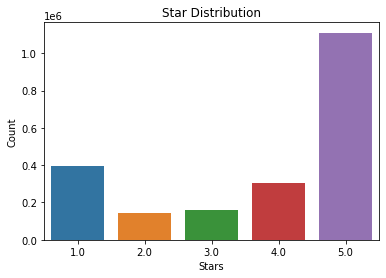

In [10]:
# Plot for Star Distribution

cplot = sns.countplot(x = 'stars', data = reviews)
cplot.set_title('Star Distribution')
cplot.set_ylabel('Count')
cplot.set_xlabel('Stars')

Text(0.5, 1.0, 'Text Length Distribution')

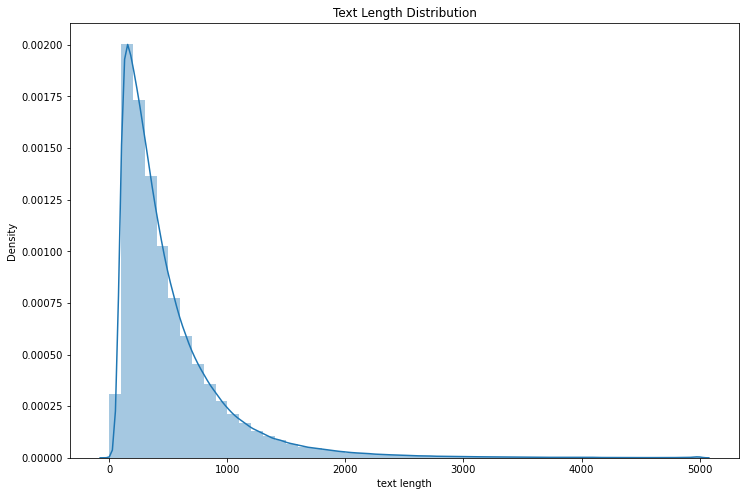

In [11]:
# Plot for the length of reviews

fig = plt.figure(figsize = (12,8))
sns.distplot(reviews['text length'], kde = True, bins = 50)
plt.title('Text Length Distribution')

## Data Cleaning

For the purpose of our analysis, we require only the 'stars' and 'text' columns. 

In [13]:
text = reviews[['stars', 'text']]
text.head()

,stars,text
0,5.0,The food is INCREDIBLE! We didn't have time to...
1,5.0,"We had a great time, and excellent service. Al..."
2,5.0,My favorite coffee shop in New Orleans for sur...
3,4.0,"Old school circa 1979, the cozy, intimate banq..."
4,1.0,"All Lowes in 20 mile radius, stopped\nstocking..."


In order to make the text reviews suitable for analysis, we must remove stopwords and punctuation and convert to lowercase. We must also remove any reviews which arent in English.

In [14]:
cachedStopWords = stopwords.words("english")

# Create a function to remove stopwords and punctuation

def remove_punc_stopwords(text):
    remove_punc = [word for word in text.lower() if word not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    return [word for word in remove_punc.split() if word not in cachedStopWords]

In [15]:
clean_text = text.copy()
clean_text['text'] = text['text'].apply(remove_punc_stopwords)

In [16]:
clean_text.head()

,stars,text
0,5.0,"[food, incredible, didnt, time, get, cocktails..."
1,5.0,"[great, time, excellent, service, food, items,..."
2,5.0,"[favorite, coffee, shop, new, orleans, sure, p..."
3,4.0,"[old, school, circa, 1979, cozy, intimate, ban..."
4,1.0,"[lowes, 20, mile, radius, stopped, stocking, w..."


To gain some sort of insight from the data, we will generate a Word Cloud with the most commonly used words in both positive and negative reviews.

In [19]:
def reviewCloud(star):
    startext = ' '.join(text[text['stars']==star]['text'])
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = STOPWORDS).generate(str(startext))

    fig = plt.figure(
        figsize = (10, 7),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)

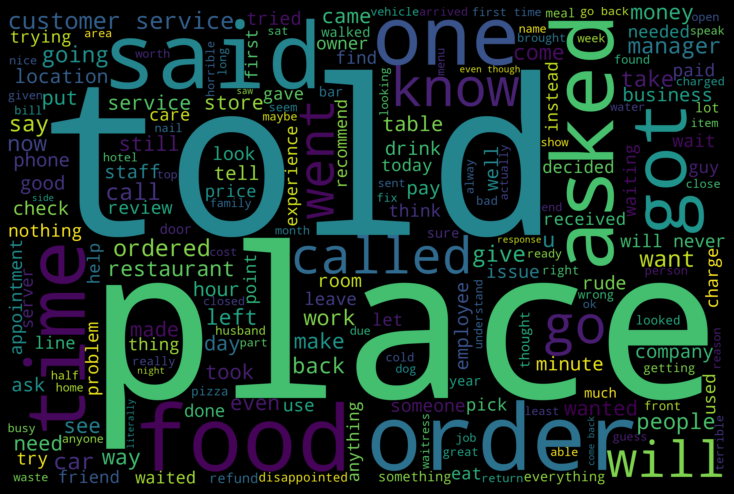

In [20]:
# WordCloud for negative reviews

reviewCloud(1)

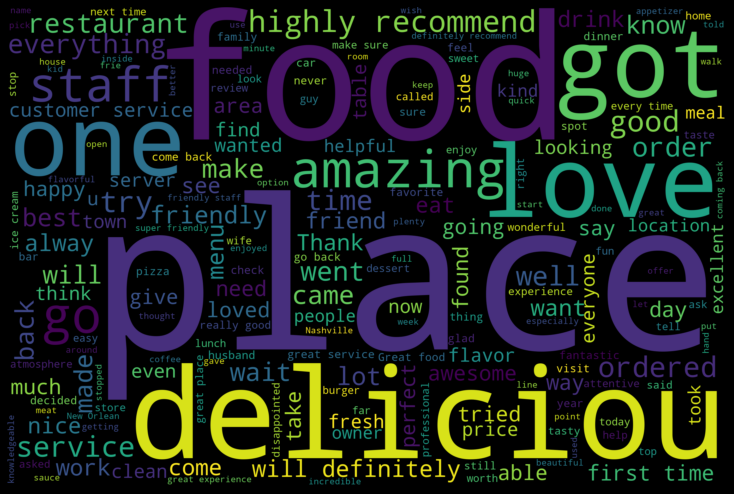

In [21]:
# WordCloud for positive reviews

reviewCloud(5)

## Building Model

Next, we will build a model to classify our reviews into positive or negative. For this, we will select only '1' and '5' stars reviews to train our model on. We will separate the dataset into x and y variables.

In [22]:
select_stars = text[(text['stars'] == 1) | (text['stars'] == 5)]

In [23]:
x = select_stars['text']
y = select_stars['stars']

### Transforming Data using CountVectorizer()

In [24]:
count_vec = CountVectorizer().fit(x)
x = count_vec.transform(x)

In [25]:
# Split data into 80% training data and 20% testing data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

## Multinomial Naive Bayes Model

For this classification problem, we will be using MultinomialNB() as it is suitable for classifying data with discrete counts (like word counts).

In [26]:
mnb = MultinomialNB()

mnb.fit(x_train, y_train)
predmnb = mnb.predict(x_test)

print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",classification_report(y_test,predmnb))

Confusion Matrix for Multinomial Naive Bayes:
[[ 72062   6881]
 [ 12987 209345]]
Score: 93.41
Classification Report:               precision    recall  f1-score   support

         1.0       0.85      0.91      0.88     78943
         5.0       0.97      0.94      0.95    222332

    accuracy                           0.93    301275
   macro avg       0.91      0.93      0.92    301275
weighted avg       0.94      0.93      0.93    301275



## Predicting

In [27]:
# For a postive review

positive_review = text['text'][1]
print(positive_review)
print("Actual Rating: ",text['stars'][1])
pr_t = count_vec.transform([positive_review])
print("Predicted Rating:")
mnb.predict(pr_t)[0]

We had a great time, and excellent service. All food items were fresh, unique, and high quality. Nothing appeared to be pre-made,
Except for the ice cream which was exceptionally good. The waitress was very sweet and friendly
Actual Rating:  5.0
Predicted Rating:


5.0

In [28]:
# For a negative review

negative_review = text['text'][4]
print(negative_review)
print("Actual Rating: ",text['stars'][4])
pr_t = count_vec.transform([negative_review])
print("Predicted Rating:")
mnb.predict(pr_t)[0]

All Lowes in 20 mile radius, stopped
stocking wood pellets for heating stove in January.  They obviously don't care about customers who purchase  $2,000. stove and have no means of using.  Thank goodness for Home Depot, my Home Center of choice now! 1 star because I had to, deserves 0.
Actual Rating:  1.0
Predicted Rating:


1.0

As we can see, our model has succesfully classified and predicted positve and negative sentiments of the Yelp reviews in our dataset with more than 90% accuracy. 